In [4]:
import os
save_dir = "results"
os.makedirs(save_dir, exist_ok=True)

Integrating ODEs with scipy.solve_ivp ...


AttributeError: module 'ntpath' has no attribute 'joim'

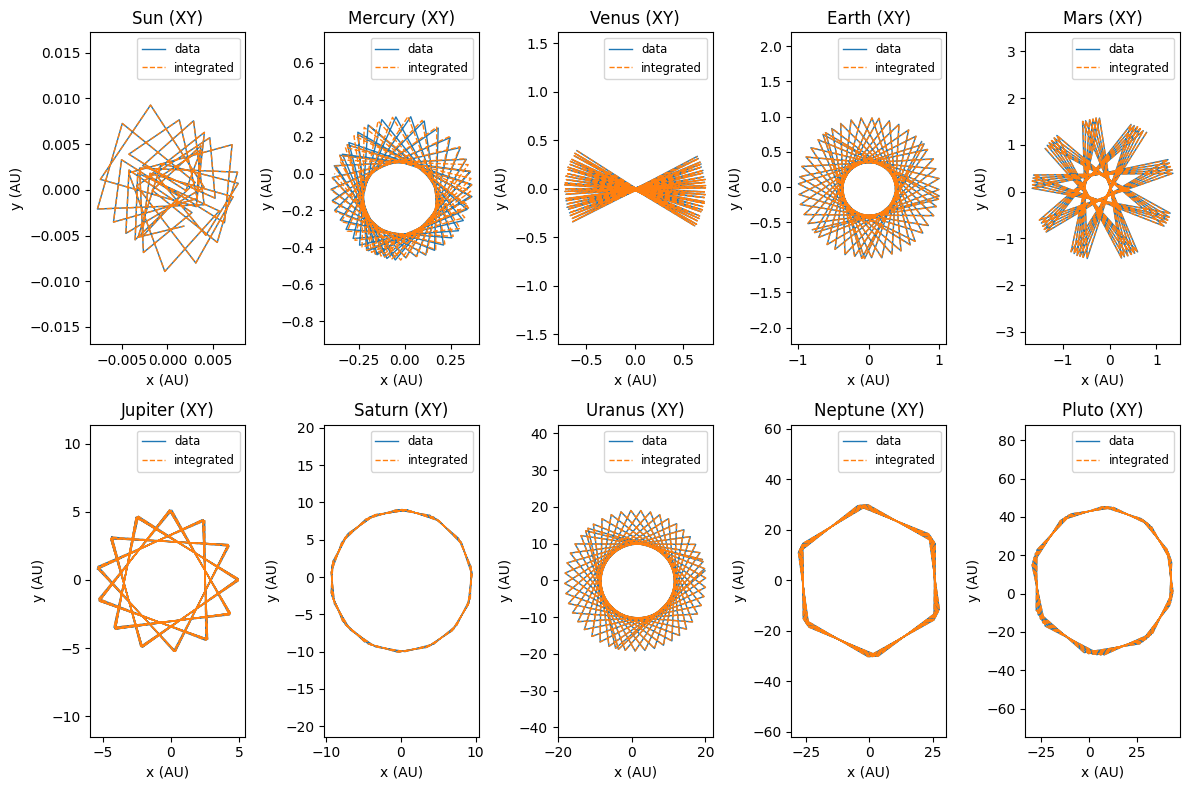

In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import os

# G used in AU^3 / (kg * day^2)
G = 1.4880826e-34

# masses (kg) (Sun, Mercury, Venus, Earth, Mars, Jupiter, Saturn, Uranus, Neptune, Pluto)
masses = np.array([
    1.988544e30,
    3.302e23,
    48.685e23,
    6.0477246e24,
    6.4185e23,
    1898.13e24,
    5.68319e26,
    86.8103e24,
    102.41e24,
    1.4639248e+22,
], dtype=float)

def nbody_deriv(t, y, masses):
    """
    y = [x0,y0,z0, x1,y1,z1, ... xN-1,yN-1,zN-1,
         vx0,vy0,vz0, vx1,vy1,vz1, ... vxN-1,vyN-1,vzN-1]
    returns dy/dt in same layout
    """
    N = masses.size
    # split positions and velocities
    pos = y[:3*N].reshape((N, 3))
    vel = y[3*N:].reshape((N, 3))

    acc = np.zeros_like(pos)

    # pairwise acceleration (O(N^2) loop)
    for i in range(N):
        ri = pos[i]
        ai = np.zeros(3)
        for j in range(N):
            if i == j: 
                continue
            rj = pos[j]
            rij = rj - ri
            dist3 = np.linalg.norm(rij)**3 + 0.0
            # avoid divide by zero (shouldn't happen)
            if dist3 == 0.0:
                continue
            ai += G * masses[j] * rij / dist3
        acc[i] = ai

    dydt = np.zeros_like(y)
    dydt[:3*N] = vel.reshape(-1) # dpos/dt = vel
    dydt[3*N:] = acc.reshape(-1) # dvel/dt = acc
    return dydt

csv_path = "state.csv"
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"state.csv not found in current folder ({os.getcwd()}). Place the CSV produced by your C program here.")

df = pd.read_csv(csv_path)
df = df.iloc[:50]

# Extract times and check columns
times = df['t'].to_numpy()
if times.ndim != 1 or times.size < 2:
    raise ValueError("state.csv must contain a time column 't' with at least two rows.")

# Determine N from header: count fields after 't' and divide by 6
n_state_cols = df.shape[1] - 1
if n_state_cols % 6 != 0:
    raise ValueError("state.csv columns after 't' should be multiple of 6 (x,y,z,vx,vy,vz per body).")
N = n_state_cols // 6
if N != masses.size:
    print(f"Warning: CSV has {N} bodies but masses array has {masses.size}. Proceeding with min(N_csv, N_masses).")
    N_use = min(N, masses.size)
    masses = masses[:N_use]
    N = N_use

# Build initial condition from the first row
first = df.iloc[0]
pos0 = np.zeros((N, 3))
vel0 = np.zeros((N, 3))
for i in range(N):
    pos0[i,0] = first[f'x{i}']
    pos0[i,1] = first[f'y{i}']
    pos0[i,2] = first[f'z{i}']
    vel0[i,0] = first[f'vx{i}']
    vel0[i,1] = first[f'vy{i}']
    vel0[i,2] = first[f'vz{i}']

y0 = np.concatenate([pos0.reshape(-1), vel0.reshape(-1)])

# Integration times: use exactly the times from CSV to make direct comparison
t_eval = times.copy()
t_span = (t_eval[0], t_eval[-1])

print("Integrating ODEs with scipy.solve_ivp ...")
sol = solve_ivp(fun=lambda t, y: nbody_deriv(t, y, masses),
                t_span=t_span, y0=y0, t_eval=t_eval,
                method='DOP853', atol=1e-12, rtol=1e-10)

if not sol.success:
    print("Warning: integrator finished with message:", sol.message)

# Extract solution positions in shape (len(t_eval), N, 3)
y_sol = sol.y.T  # shape (nt, 6*N)
pos_sol = y_sol[:, :3*N].reshape((len(t_eval), N, 3))

vel_sol = y_sol[:, 3*N:].reshape((len(t_eval), N, 3))
vel_csv = np.zeros_like(vel_sol)
for k, row in enumerate(df.itertuples(index=False)):
    for i in range(N):
        vel_csv[k, i, 0] = getattr(row, f'vx{i}')
        vel_csv[k, i, 1] = getattr(row, f'vy{i}')
        vel_csv[k, i, 2] = getattr(row, f'vz{i}')


# Extract ground-truth positions from CSV
pos_csv = np.zeros_like(pos_sol)
for k, row in enumerate(df.itertuples(index=False)):
    # row[0] is t, subsequent fields x0,y0,z0,vx0,... etc in header order
    # easier to access by column names
    for i in range(N):
        pos_csv[k, i, 0] = getattr(row, f'x{i}')
        pos_csv[k, i, 1] = getattr(row, f'y{i}')
        pos_csv[k, i, 2] = getattr(row, f'z{i}')

# plot comparision
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)
N = pos_csv.shape[1]

# ;ist of body names matching the order in your simulation
body_names = ['Sun', 'Mercury', 'Venus', 'Earth', 'Mars', 
              'Jupiter', 'Saturn', 'Uranus', 'Neptune', 'Pluto']

# XY orbit overlay per body
fig1, axes = plt.subplots(2, (N+1)//2, squeeze=False)
axes = axes.flatten()
for i in range(N):
    ax = axes[i]
    ax.plot(pos_csv[:, i, 0], pos_csv[:, i, 1], '-', label='data', linewidth=1)
    ax.plot(pos_sol[:, i, 0], pos_sol[:, i, 1], '--', label='integrated', linewidth=1)
    ax.set_title(f'{body_names[i]} (XY)')
    ax.set_xlabel('x (AU)')
    ax.set_ylabel('y (AU)')
    ax.axis('equal')
    ax.legend(fontsize='small')
# hide unused axes
for j in range(N, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.savefig(os.path.join(save_dir,'orbits_xy_overlay.png', dpi=200))
plt.show()

# velocity components per body

fig2, axes = plt.subplots(2, (N+1)//2, squeeze=False)
axes = axes.flatten()

components = ['vx', 'vy', 'vz']
linestyles = ['-', '--']

for i in range(N):
    ax = axes[i]

    for j in range(3):
        ax.plot(t_eval, vel_csv[:, i, j],
                '-', linewidth=1,
                label=f'{components[j]} data')
        ax.plot(t_eval, vel_sol[:, i, j],
                '--', linewidth=1,
                label=f'{components[j]} integrated')

    ax.set_title(f'{body_names[i]} velocities')
    ax.set_xlabel('time (days)')
    ax.set_ylabel('velocity (AU/day)')
    ax.legend(fontsize='small')

# hide unused axes
for j in range(N, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(save_dir,'vel_components_all_bodies.png', dpi=200))
plt.show()


TypeError: join() got an unexpected keyword argument 'dpi'

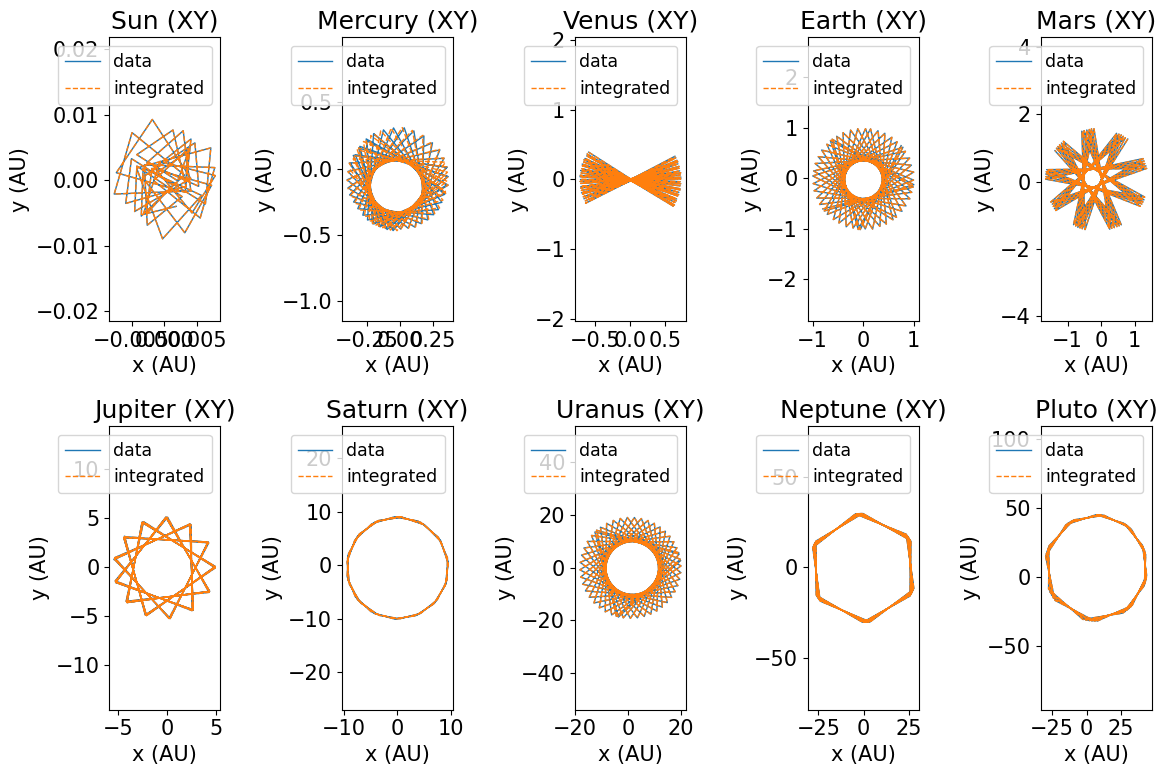

In [10]:
fig1, axes = plt.subplots(2, (N+1)//2, squeeze=False)
axes = axes.flatten()
for i in range(N):
    ax = axes[i]
    ax.plot(pos_csv[:, i, 0], pos_csv[:, i, 1], '-', label='data', linewidth=1)
    ax.plot(pos_sol[:, i, 0], pos_sol[:, i, 1], '--', label='integrated', linewidth=1)
    ax.set_title(f'{body_names[i]} (XY)')
    ax.set_xlabel('x (AU)')
    ax.set_ylabel('y (AU)')
    ax.axis('equal')
    ax.legend(fontsize='small')
# hide unused axes
for j in range(N, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.savefig(os.path.join(save_dir,'orbits_xy_overlay.png', dpi=200))
plt.show()

# velocity components per body

fig2, axes = plt.subplots(2, (N+1)//2, squeeze=False)
axes = axes.flatten()

components = ['vx', 'vy', 'vz']
linestyles = ['-', '--']

for i in range(N):
    ax = axes[i]

    for j in range(3):
        ax.plot(t_eval, vel_csv[:, i, j],
                '-', linewidth=1,
                label=f'{components[j]} data')
        ax.plot(t_eval, vel_sol[:, i, j],
                '--', linewidth=1,
                label=f'{components[j]} integrated')

    ax.set_title(f'{body_names[i]} velocities')
    ax.set_xlabel('time (days)')
    ax.set_ylabel('velocity (AU/day)')
    ax.legend(fontsize='small')

# hide unused axes
for j in range(N, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(save_dir,'vel_components_all_bodies.png'))
plt.show()